In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

import emcee
import corner
import matplotlib as mpl
import seaborn as sns
import arviz as az


%matplotlib inline
np.random.seed(1234)

az.style.use("arviz-darkgrid")

# Nice plotting options.

params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

# Gaussian-Gaussian example

We consider a scenario where noise ($ n $) and signal ($\theta$) both are normally distributed, i.e. $n  \sim \mathcal{N}(0, \sigma^2)$ and $\theta \sim \mathcal{N}(\mu, \Sigma^2)$.

Then, observations

$$d = \theta + n$$

### (a) Compute the likelihood of hyper-parameters ($\mu, \Sigma$):

#### (a-i): Analytical

$$p(d|\lambda \equiv \{\mu, \Sigma, \sigma \}) = \frac{1}{\alpha(\lambda)} \int d\theta p(d|\theta) p(\theta|\lambda)$$

Analytical calculation will render:

$$p(d|\lambda) = \frac{1}{\alpha(\lambda)} \frac{1}{\sqrt{2 \pi (\sigma^2 + \Sigma^2)}} \exp \left[ -\frac{(d-\mu)^2}{2(\sigma^2 + \Sigma^2)}\right] \equiv \frac{1}{\alpha(\lambda)} \mathcal{N}(\mu, \sigma^2 + \Sigma^2)$$

Where $\alpha(\lambda)$ is the selection effect here:

$$\alpha(\lambda) = \int_{d_{\mathrm{th}}}^\infty d d \int d\theta p(d|\theta) p(\theta|\lambda) = \int_{d_{\mathrm{th}}}^\infty d d \mathcal{N}(\mu, \sigma^2 + \Sigma^2) $$

$$\alpha(\lambda) = \frac{1}{2} \mathrm{erfc} \left[ \frac{d_{\mathrm{th}} - \mu}{\sqrt{2 (\sigma^2 + \Sigma^2)}} \right] $$


### (b) plotting the observations

In [3]:
mu_true = 0.5 
Sigma_true =1 
sigma_true = 0.1

In [4]:
# number of samples
N_samples = 10**5

# generating samples
theta = np.random.normal(mu_true, Sigma_true, N_samples)

# generating noise
noise = np.random.normal(0.0, sigma_true, N_samples)

# Observations
data = theta + noise

In [5]:
d_th = 0.0

selected_indices = data > d_th

data_selection_effects = data[selected_indices]

Text(0.5, 0, '$d$')

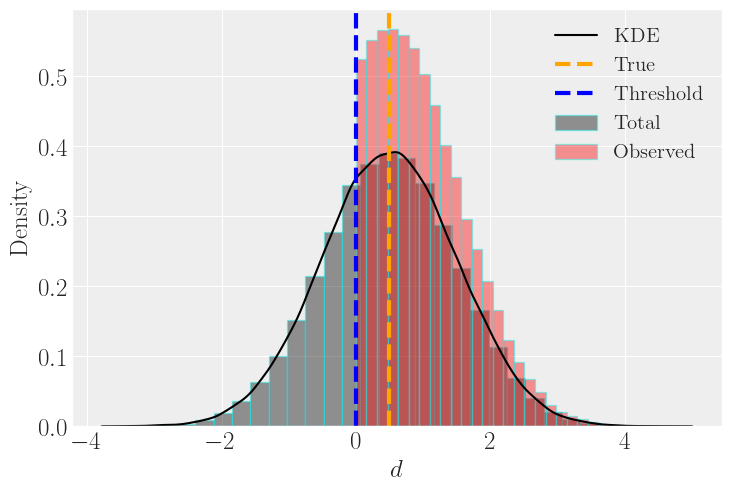

In [6]:
#plt.figure(figsize=(10, 7))
plt.hist(data, density=True,label='Total',bins=30,histtype = 'bar',
                               color ='black', alpha=0.4, edgecolor='cyan')
plt.hist(data_selection_effects, density=True,label='Observed',bins=30,histtype = 'bar',
                               color ='r', alpha=0.4, edgecolor='cyan')
sns.kdeplot(np.array(data), label='KDE',c='black')
plt.axvline(x=mu_true, label='True', c='orange',ls='--',lw=3)
plt.axvline(x=d_th, label='Threshold', c='b',ls='--',lw=3)
plt.ylabel('Density')
plt.legend(loc='best')
plt.xlabel('$d$')
#plt.grid()

### (c)  posterior on hyper-parameters:

#### (c-i) Analytical

$$p(\lambda|d) \propto \pi(\lambda) p(d|\lambda) = \frac{\pi(\lambda)}{\alpha(\lambda)} \frac{1}{\sqrt{2 \pi (\sigma^2 + \Sigma^2)}} \exp \left[ -\frac{(d-\mu)^2}{2(\sigma^2 + \Sigma^2)}\right] \equiv \mathcal{N}(\mu, \sigma^2 + \Sigma^2) \frac{\pi(\lambda)}{\alpha(\lambda)}$$

In [11]:
def model(data, mu, Sigma, sigma):
    
    num = np.exp(- (data - mu)**2 / (2 * (Sigma**2 + sigma**2)))
    den = np.sqrt(2 * np.pi * (Sigma**2 + sigma**2))
    
    return num / den   

In [21]:
# Define limits of support for the likelihood, i.e. the limits of flat priors.
mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = 1e-6
Sigma_sq_max_prior = 5.0

#assume that width of the noise distribution is known
sigma = sigma_true

def log_likelihood(params, data):
    
    # Specify a set of flat priors.
    if (params[0] >= mean_min_prior)& (params[0] <= mean_max_prior)& (params[1] >= Sigma_sq_min_prior)& (params[1] <= Sigma_sq_max_prior) == 1:
        
        model_probability = model(data, params[0], np.sqrt(params[1]), sigma)
        pdet_lambda = 0.5 * erfc((d_th - params[0])/np.sqrt(2 * (params[1] + sigma**2)))
        log_likelihood = np.sum(np.log(model_probability/pdet_lambda))
            
        return log_likelihood
    
    else:
        return -np.inf

In [22]:
n_iter = 10000
ndim, nwalkers = 2, 4

# Initialize MCMC: here's where params[0] and params[1] are effectively defined.

pos_init0 = [mu_true, Sigma_true**2]

# Perturb the initial position by a bit.

p0 = pos_init0*(1+0.001* np.random.randn(2*len(pos_init0), len(pos_init0)))


# Run the MCMC here.

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data_selection_effects])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:57<00:00, 56.18it/s]


In [24]:
"""
Collect the samples here.
"""
burnin = 1500 # discard first 1500 points.

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() #- sigma**2 # remove sigma here.
org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (34000, 2)
median =  [0.51678499 0.98697332]


/home/mukesh/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


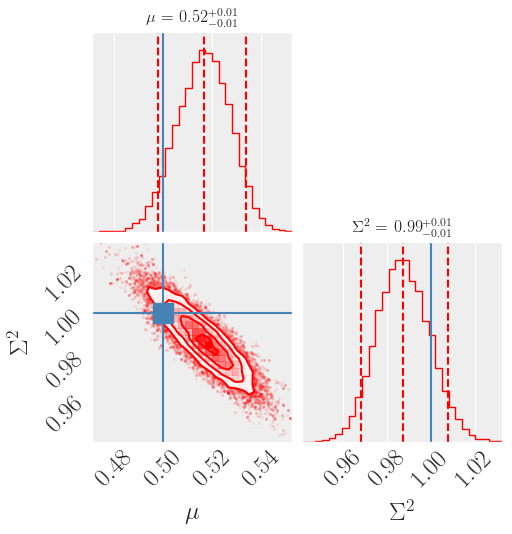

In [25]:
figure = corner.corner(org_samp, bins=30, color='r', labels=[r"$\mu$", r"$\Sigma^2$"],
                      show_titles=True, title_kwargs={"fontsize": 12}, truths=[mu_true, Sigma_true**2],
                      quantiles=[0.05, 0.5, 0.95])

#### (c-i) Numerical

In [26]:
# number of samples
N_samples = 2*10**2

# generating samples
theta = np.random.normal(mu_true, Sigma_true, N_samples)

# generating noise
noise = np.random.normal(0.0, sigma_true, N_samples)

# Observations
data = theta + noise

In [27]:
d_th = 0.0

selected_indices = data > d_th

data_selection_effects = data[selected_indices]

Text(0.5, 0, '$d$')

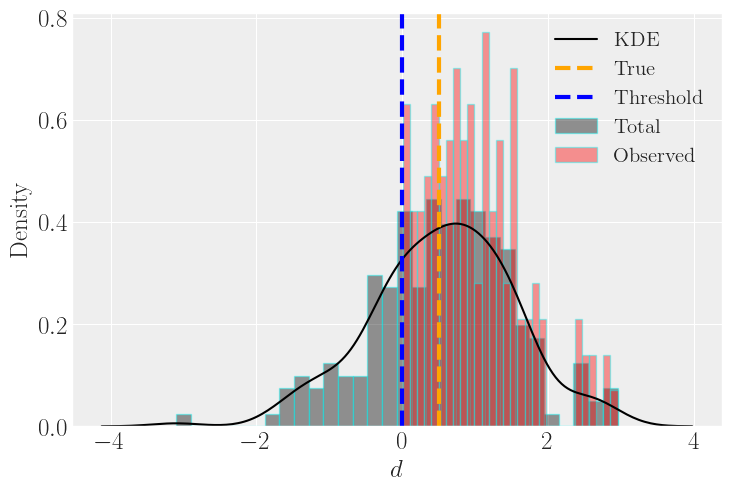

In [28]:
#plt.figure(figsize=(10, 7))
plt.hist(data, density=True,label='Total',bins=30,histtype = 'bar',
                               color ='black', alpha=0.4, edgecolor='cyan')
plt.hist(data_selection_effects, density=True,label='Observed',bins=30,histtype = 'bar',
                               color ='r', alpha=0.4, edgecolor='cyan')
sns.kdeplot(np.array(data), label='KDE',c='black')
plt.axvline(x=mu_true, label='True', c='orange',ls='--',lw=3)
plt.axvline(x=d_th, label='Threshold', c='b',ls='--',lw=3)
plt.ylabel('Density')
plt.legend(loc='best')
plt.xlabel('$d$')
#plt.grid()

In [29]:
def model_prob(theta, mu, Sigma):
    
    num = np.exp(- (theta - mu)**2 / (2 * Sigma**2))
    den = np.sqrt(2 * np.pi * Sigma**2)
    
    return num / den

In [30]:
# Define limits of support for the likelihood, i.e. the limits of flat priors.
mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = 1e-6
Sigma_sq_max_prior = 5.0

#assume that width of the noise distribution is known
sigma = sigma_true

def log_likelihood(params, data):
    
    # Specify a set of flat priors.
    if (params[0] >= mean_min_prior)& (params[0] <= mean_max_prior)& (params[1] >= Sigma_sq_min_prior)& (params[1] <= Sigma_sq_max_prior) == 1:
        #draw samples
        log_likelihood = 0.0
        for d in data:
            theta_samples = np.random.normal(d, sigma, 10000)
            N_draw = len(theta_samples)

            model_probability = model_prob(theta_samples, params[0], np.sqrt(params[1]))
            
            log_likelihood_one_observation = np.log(np.sum(model_probability)) - np.log(N_draw)
            pdet_lambda = 0.5 * erfc((d_th - params[0])/np.sqrt(2 * params[1]))
            log_likelihood += log_likelihood_one_observation - np.log(pdet_lambda)
            
        return log_likelihood
    
    else:
        return -np.inf

In [32]:
n_iter = 1000
ndim, nwalkers = 2, 4

# Initialize MCMC: here's where params[0] and params[1] are effectively defined.

pos_init0 = [mu_true, Sigma_true**2]

# Perturb the initial position by a bit.

p0 = pos_init0*(1+0.001* np.random.randn(2*len(pos_init0), len(pos_init0)))


# Run the MCMC here.

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data_selection_effects])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:16<00:00,  2.29it/s]


In [33]:
"""
Collect the samples here.
"""
burnin = 500 # discard first 1500 points.

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() #- sigma**2 # remove sigma here.
org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (2000, 2)
median =  [0.5746621  0.90194459]


In [34]:
org_samp

array([[0.74822618, 0.79826984],
       [0.59452651, 0.89923763],
       [0.89960056, 0.63819564],
       ...,
       [0.7055035 , 0.69902535],
       [0.72385469, 0.75729312],
       [0.42239698, 1.12272514]])

In [35]:
#chains = sampler.get_chain(discard=1, thin=1, flat=False)
#mu_samples = chains[:,:,0].flatten()
#Sigma2_samples = chains[:,:,1].flatten()

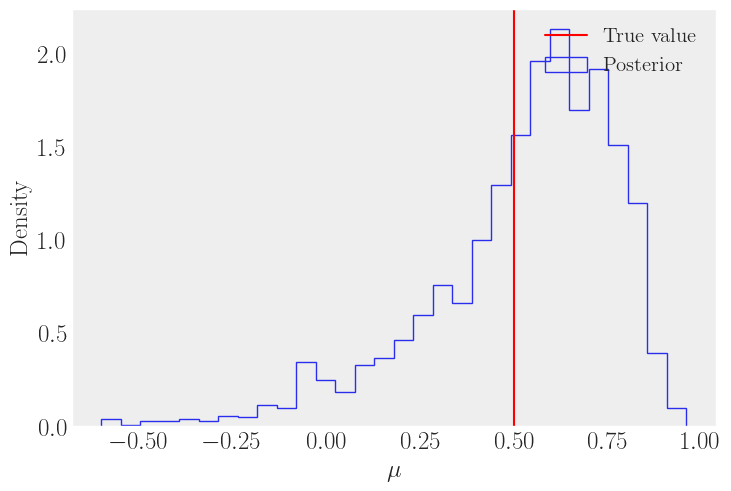

In [36]:
plt.hist(mu_samples, bins=30, density=True, histtype=u'step', label="Posterior")
plt.axvline(x=mu_true, c="r", label="True value")
plt.xlabel("$\mu$")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid()

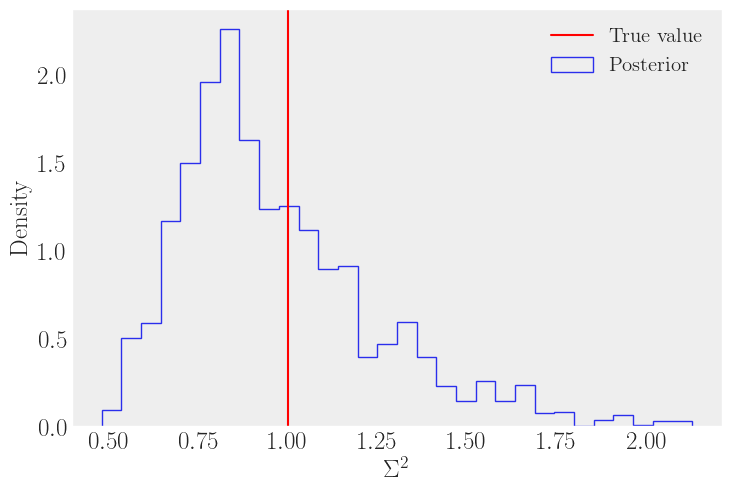

In [37]:
plt.hist(Sigma2_samples, bins=30, density=True, histtype=u'step', label="Posterior")
plt.axvline(x=Sigma_true**2, c="r", label="True value")
plt.xlabel("$\Sigma^2$")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid()

/home/mukesh/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


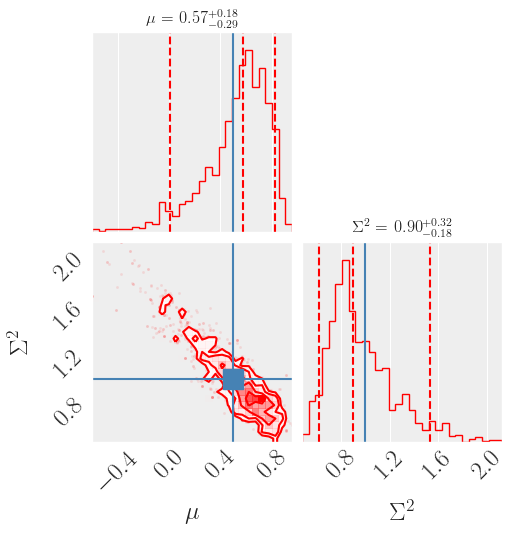

In [38]:
figure = corner.corner(org_samp, bins=30, color='r', labels=[r"$\mu$", r"$\Sigma^2$"],
                      show_titles=True, title_kwargs={"fontsize": 12}, truths=[mu_true, Sigma_true**2],
                      quantiles=[0.05, 0.5, 0.95])